In [2]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

Matplotlib is building the font cache; this may take a moment.


tensorflow 2.6.0


In [4]:
# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10

# 데이터 로드 및 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# train_x 크기 확인
print(train_x.shape)

(50000, 32, 32, 3)


In [5]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
train_x = (train_x / 127.5) - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [77]:
train_x.shape

TensorShape([50000, 32, 32, 3])

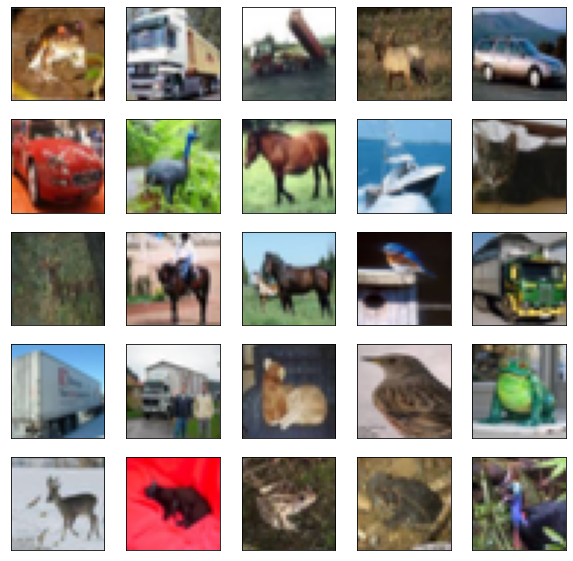

Batch shape: (256, 32, 32, 3)


In [78]:
# 학습 데이터 시각화
def visualize_data(data, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((data[i] + 1) / 2)  # 정규화 해제 후 출력
    plt.show()

# 데이터 확인
visualize_data(train_x)

# 미니배치 데이터셋 구성
BATCH_SIZE = 256
BUFFER_SIZE = 60000

# tf.data.Dataset을 활용하여 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 데이터셋 확인
for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)


In [85]:
from tensorflow.keras import layers
import tensorflow as tf

def build_generator(latent_dim):
    model = tf.keras.Sequential()
    # Dense 레이어로 8*8*128을 출력
    model.add(layers.Dense(8 * 8 * 128, activation="relu", input_dim=latent_dim))  # latent_dim -> 8x8x128
    model.add(layers.Reshape((8, 8, 128)))  # 8x8x128 형태로 reshape
    
    # 첫 번째 Conv2DTranspose 레이어: 크기를 16x16으로 증가
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"))  # 16x16
    # 두 번째 Conv2DTranspose 레이어: 크기를 32x32으로 증가
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"))   # 32x32
    # 마지막 Conv2DTranspose 레이어: 색상 채널을 3으로 설정하고, 이미지 크기 32x32 유지
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=1, padding="same", activation="tanh"))    # 32x32로 맞춰짐

    return model

latent_dim = 100  # Latent 벡터 차원
generator = build_generator(latent_dim)

# 테스트 노이즈로 생성된 이미지의 shape 확인
noise = tf.random.normal([1, latent_dim])  # 1개의 배치로 노이즈 생성
fake_images = generator(noise, training=False)
print(fake_images.shape)  # (1, 32, 32, 3) 출력되어야 함


(1, 32, 32, 3)


In [ ]:
# 생성된 이미지 시각화
plt.figure(figsize=(4, 4))
plt.imshow((generated_image[0] + 1) / 2)  # [-1, 1] -> [0, 1]로 변환하여 시각화
plt.axis('off')
plt.show()


In [72]:
train_x = tf.image.resize(train_x, (32, 32))  # 이미지 크기를 32x32로 변경

In [73]:
print(train_x.shape)


(50000, 32, 32, 3)


In [86]:
fake_images = generator(noise, training=True)
print(fake_images.shape)  # fake_images의 shape 확인


(1, 32, 32, 3)


In [87]:
# Generator 모델 확인
latent_dim = 100  # Latent 벡터 차원
generator = build_generator(latent_dim)

# 테스트 노이즈로 생성된 이미지의 shape 확인
noise = tf.random.normal([1, latent_dim])  # 1개의 배치로 노이즈 생성
fake_images = generator(noise, training=False)
print(fake_images.shape)


(1, 32, 32, 3)


In [89]:
from tensorflow.keras import layers

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))  # 입력 크기 (32, 32, 3)
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='leaky_relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류 (진짜/가짜)
    
    return model

discriminator = build_discriminator()


In [91]:
import tensorflow as tf

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자 손실 함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 생성자는 가짜 이미지를 진짜처럼 만들고자 함

# 디스크리미네이터 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 실제 이미지를 진짜로 분류
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜 이미지를 가짜로 분류
    return real_loss + fake_loss


In [92]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [98]:
@tf.function
def train_step(batch):
    noise = tf.random.normal([batch.shape[0], latent_dim])  # 배치 크기에 맞게 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 생성된 가짜 이미지
        real_output = discriminator(batch, training=True)  # 진짜 이미지에 대한 판별자 출력
        fake_output = discriminator(generated_images, training=True)  # 가짜 이미지에 대한 판별자 출력

        gen_loss = generator_loss(fake_output)  # 생성자 손실
        disc_loss = discriminator_loss(real_output, fake_output)  # 디스크리미네이터 손실

    # 그래디언트 계산 및 최적화
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [100]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256  # 적절한 배치 크기 설정

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 데이터셋이 제대로 배치 크기를 반환하는지 확인
for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)


Batch shape: (256, 32, 32, 3)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Epoch 1/50, Generator Loss: 1.2530286312103271, Discriminator Loss: 1.001770257949829
Time for epoch 1 is 11.88021993637085 sec
Epoch 2/50, Generator Loss: 1.6168100833892822, Discriminator Loss: 0.7097575664520264
Time for epoch 2 is 11.29239559173584 sec
Epoch 3/50, Generator Loss: 1.6838905811309814, Discriminator Loss: 0.779279887676239
Time for epoch 3 is 11.420191526412964 sec
Epoch 4/50, Generator Loss: 1.4662582874298096, Discriminator Loss: 0.7257919311523438
Time for epoch 4 is 11.482144117355347 sec
Epoch 5/50, Generator Loss: 1.151930570602417, Discriminator Loss: 1.1872882843017578
Time for epoch 5 is 11.297342777252197 sec
Epoch 6/50, Generator Loss: 1.7105058431625366, Discriminator Loss: 0.7924033403396606
Time for epoch 6 is 11.183613061904907 sec
Epoch 7/50, Generator Loss: 1.3958021402359009, Discriminator Loss: 0.8598673939704895
Time for epoch 7 is 11.147902011871338 sec
Epoch 8/50, Generator Loss: 0.8332942724227905, Discriminator Loss: 1.5321614742279053
Time for

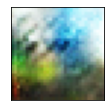

Time for epoch 10 is 11.2776198387146 sec
Epoch 11/50, Generator Loss: 1.152160406112671, Discriminator Loss: 1.1079754829406738
Time for epoch 11 is 11.298393249511719 sec
Epoch 12/50, Generator Loss: 1.1798465251922607, Discriminator Loss: 1.032350778579712
Time for epoch 12 is 11.304701566696167 sec
Epoch 13/50, Generator Loss: 1.3016475439071655, Discriminator Loss: 1.1526306867599487
Time for epoch 13 is 11.22942566871643 sec
Epoch 14/50, Generator Loss: 1.1066806316375732, Discriminator Loss: 1.1650238037109375
Time for epoch 14 is 11.203578472137451 sec
Epoch 15/50, Generator Loss: 1.1384871006011963, Discriminator Loss: 1.1376347541809082
Time for epoch 15 is 11.213235139846802 sec
Epoch 16/50, Generator Loss: 1.478140115737915, Discriminator Loss: 0.7813995480537415
Time for epoch 16 is 11.202150583267212 sec
Epoch 17/50, Generator Loss: 0.8668895959854126, Discriminator Loss: 1.5157487392425537
Time for epoch 17 is 11.194354772567749 sec
Epoch 18/50, Generator Loss: 1.0293234

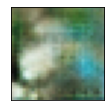

Time for epoch 20 is 11.268382549285889 sec
Epoch 21/50, Generator Loss: 0.870095431804657, Discriminator Loss: 1.5193564891815186
Time for epoch 21 is 11.217788457870483 sec
Epoch 22/50, Generator Loss: 1.00080406665802, Discriminator Loss: 1.1408488750457764
Time for epoch 22 is 11.246204376220703 sec
Epoch 23/50, Generator Loss: 1.5591959953308105, Discriminator Loss: 0.7050615549087524
Time for epoch 23 is 11.339555978775024 sec
Epoch 24/50, Generator Loss: 0.7012303471565247, Discriminator Loss: 2.1038031578063965
Time for epoch 24 is 21.370823860168457 sec
Epoch 25/50, Generator Loss: 1.0938117504119873, Discriminator Loss: 1.1599433422088623
Time for epoch 25 is 11.242904901504517 sec
Epoch 26/50, Generator Loss: 1.0947544574737549, Discriminator Loss: 0.9774950742721558
Time for epoch 26 is 11.329336643218994 sec
Epoch 27/50, Generator Loss: 0.9261218309402466, Discriminator Loss: 1.4736968278884888
Time for epoch 27 is 11.478161573410034 sec
Epoch 28/50, Generator Loss: 0.7738

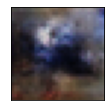

Time for epoch 30 is 11.147305011749268 sec
Epoch 31/50, Generator Loss: 0.7871474027633667, Discriminator Loss: 1.726615071296692
Time for epoch 31 is 11.166173696517944 sec
Epoch 32/50, Generator Loss: 0.8686978220939636, Discriminator Loss: 1.320778727531433
Time for epoch 32 is 11.196163654327393 sec
Epoch 33/50, Generator Loss: 1.118307113647461, Discriminator Loss: 1.120868444442749
Time for epoch 33 is 11.235763311386108 sec
Epoch 34/50, Generator Loss: 0.8282249569892883, Discriminator Loss: 1.7649019956588745
Time for epoch 34 is 11.265205144882202 sec
Epoch 35/50, Generator Loss: 0.8944646120071411, Discriminator Loss: 1.6853734254837036
Time for epoch 35 is 11.25926661491394 sec
Epoch 36/50, Generator Loss: 0.9029619097709656, Discriminator Loss: 1.4395475387573242
Time for epoch 36 is 11.218414545059204 sec
Epoch 37/50, Generator Loss: 0.639041543006897, Discriminator Loss: 1.5519856214523315
Time for epoch 37 is 11.189795970916748 sec
Epoch 38/50, Generator Loss: 0.9063578

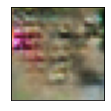

Time for epoch 40 is 11.24519157409668 sec
Epoch 41/50, Generator Loss: 1.3359465599060059, Discriminator Loss: 1.0794789791107178
Time for epoch 41 is 11.171652555465698 sec
Epoch 42/50, Generator Loss: 0.7957431077957153, Discriminator Loss: 1.4941480159759521
Time for epoch 42 is 11.219080686569214 sec
Epoch 43/50, Generator Loss: 0.8549729585647583, Discriminator Loss: 1.2837939262390137
Time for epoch 43 is 11.218666553497314 sec
Epoch 44/50, Generator Loss: 0.8165742754936218, Discriminator Loss: 1.3403854370117188
Time for epoch 44 is 11.212311029434204 sec
Epoch 45/50, Generator Loss: 0.9642637968063354, Discriminator Loss: 1.3046892881393433
Time for epoch 45 is 11.187755584716797 sec
Epoch 46/50, Generator Loss: 1.0782661437988281, Discriminator Loss: 1.0015299320220947
Time for epoch 46 is 11.182637691497803 sec
Epoch 47/50, Generator Loss: 0.8018063306808472, Discriminator Loss: 1.441250205039978
Time for epoch 47 is 11.229748964309692 sec
Epoch 48/50, Generator Loss: 1.176

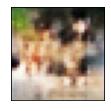

Time for epoch 50 is 11.217489242553711 sec


In [103]:
import time

EPOCHS = 50  # 학습할 에폭 수

for epoch in range(EPOCHS):
    start_time = time.time()

    for batch in train_dataset:
        gen_loss, disc_loss = train_step(batch)

    print(f'Epoch {epoch+1}/{EPOCHS}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

    # 주기적으로 생성된 이미지 시각화
    if (epoch + 1) % 10 == 0:
        noise = tf.random.normal([1, latent_dim])  # 노이즈 생성
        generated_images = generator(noise, training=False)
        visualize_data(generated_images.numpy())  # 생성된 이미지 시각화

    print(f'Time for epoch {epoch + 1} is {time.time() - start_time} sec')


다시해보기..

In [110]:
import tensorflow as tf

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10

# 데이터 로드 및 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# train_x 크기 확인
print(train_x.shape)


(50000, 32, 32, 3)


In [111]:
train_x = train_x / 127.5 - 1  # 정규화: [-1, 1] 범위로


In [112]:
# 데이터셋을 TensorFlow Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices(train_x)
train_dataset = train_dataset.shuffle(60000).batch(64)


In [113]:
from tensorflow.keras import layers
import tensorflow as tf

def build_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 128, activation="relu", input_dim=latent_dim))  # Latent 벡터 -> 8x8x128
    model.add(layers.Reshape((8, 8, 128)))  # 8x8x128 형태로 reshape
    
    # Conv2DTranspose로 이미지 크기 확장
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"))  # 16x16
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"))   # 32x32
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=1, padding="same", activation="tanh"))    # 32x32, 3채널 (RGB)

    return model

# Latent 벡터 차원
latent_dim = 100  
generator = build_generator(latent_dim)

# 랜덤 노이즈로 이미지 생성
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)
print(generated_image.shape)  # (1, 32, 32, 3)


(1, 32, 32, 3)


In [114]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))  # 입력 이미지 크기 (32, 32, 3)
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='leaky_relu'))
    model.add(layers.Flatten())  # 이미지를 1D로 펼침
    model.add(layers.Dense(1, activation='sigmoid'))  # 0과 1로 판별 (진짜/가짜)
    
    return model

# 판별자 모델 빌드
discriminator = build_discriminator()

# 랜덤 이미지 판별
real_image = tf.random.normal([1, 32, 32, 3])  # 가짜 이미지를 생성
fake_output = discriminator(real_image, training=False)
print(fake_output.shape)  # (1, 1) 출력, 0 또는 1로 판별됨


(1, 1)


In [115]:
# 손실 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자 손실
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 생성자는 가짜 이미지를 진짜처럼 만들고자 함

# 판별자 손실
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 실제 이미지를 진짜로 판별
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜 이미지를 가짜로 판별
    return real_loss + fake_loss

# 최적화 함수 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [116]:
@tf.function
def train_step(batch):
    noise = tf.random.normal([batch.shape[0], latent_dim])  # 배치 크기만큼 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 생성된 이미지
        real_output = discriminator(batch, training=True)  # 실제 이미지에 대한 판별자 출력
        fake_output = discriminator(generated_images, training=True)  # 가짜 이미지에 대한 판별자 출력

        gen_loss = generator_loss(fake_output)  # 생성자 손실
        disc_loss = discriminator_loss(real_output, fake_output)  # 판별자 손실

    # 그래디언트 계산 및 최적화
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [117]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

# 학습 진행 중 모델 저장
checkpoint.save(checkpoint_dir)

# 학습 과정에서 이미지를 생성하고 저장
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # [-1, 1] 범위 -> [0, 1] 범위로 변환
        plt.axis('off')
    plt.savefig(f'./generated_samples/image_at_epoch_{epoch}.png')
    plt.close()


In [119]:
import os

# 디렉토리가 없으면 생성
if not os.path.exists('./generated_samples'):
    os.makedirs('./generated_samples')

# 이미지 저장
plt.savefig(f'./generated_samples/image_at_epoch_{epoch}.png')


<Figure size 432x288 with 0 Axes>

In [120]:
EPOCHS = 50
for epoch in range(EPOCHS):
    for batch in train_dataset:
        gen_loss, disc_loss = train_step(batch)

    print(f'Epoch {epoch+1}/{EPOCHS}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

    # 주기적으로 생성된 이미지 시각화
    if (epoch + 1) % 10 == 0:
        noise = tf.random.normal([16, latent_dim])  # 16개의 고정된 노이즈 생성
        generate_and_save_images(generator, epoch + 1, noise)

    # 모델 저장
    checkpoint.save(checkpoint_dir)


Epoch 1/50, Generator Loss: 2.4171199798583984, Discriminator Loss: 1.1408051252365112
Epoch 2/50, Generator Loss: 2.5785462856292725, Discriminator Loss: 0.5522574186325073
Epoch 3/50, Generator Loss: 1.7065584659576416, Discriminator Loss: 0.8296959400177002
Epoch 4/50, Generator Loss: 1.1361767053604126, Discriminator Loss: 0.754403293132782
Epoch 5/50, Generator Loss: 1.1570899486541748, Discriminator Loss: 0.8661751747131348
Epoch 6/50, Generator Loss: 1.5547020435333252, Discriminator Loss: 0.341011643409729
Epoch 7/50, Generator Loss: 2.4062798023223877, Discriminator Loss: 0.438480943441391
Epoch 8/50, Generator Loss: 1.8570517301559448, Discriminator Loss: 0.5970397591590881
Epoch 9/50, Generator Loss: 1.3708198070526123, Discriminator Loss: 1.1470677852630615
Epoch 10/50, Generator Loss: 3.708505153656006, Discriminator Loss: 1.6327199935913086
Epoch 11/50, Generator Loss: 1.7770884037017822, Discriminator Loss: 1.00383460521698
Epoch 12/50, Generator Loss: 2.136935234069824,

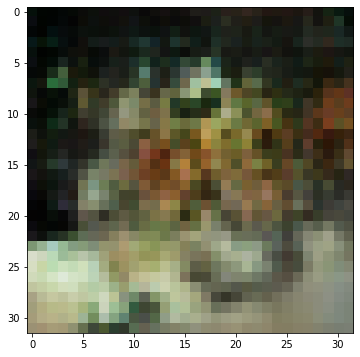

In [136]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

# 모델 로드 후 이미지 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()


In [127]:
import glob
import imageio
import os

# 수정된 anim_file 경로 (CIFAR-10 경로로 변경)
anim_file = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples/cifar10_dcgan.gif'

# CIFAR-10의 generated_samples 폴더에서 이미지를 찾기 위해 경로 수정
filenames = glob.glob(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_*.png')

# filenames에 있는 파일들을 출력하여 확인
print(f"Found {len(filenames)} files.")
print(filenames)

if len(filenames) == 0:
    print("No images found in the specified directory.")
else:
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(filenames)  # 이미지 파일들을 오름차순으로 정렬
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2 * (i ** 0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        # 마지막 이미지 추가
        image = imageio.imread(filenames[-1])
        writer.append_data(image)

    # 결과 확인
    print(f"GIF file saved at: {anim_file}")


Found 6 files.
['/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_9.png', '/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_40.png', '/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_30.png', '/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_50.png', '/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_20.png', '/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/image_at_epoch_10.png']
GIF file saved at: /aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/cifar10_dcgan.gif
